# Определение возраста покупателей

## Исследовательский анализ данных

**Импортируем необходимые библиотеки.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Установим путь к данным, выгрузим CSV файл и выведем первые строки.**

In [2]:
# Установим путь к данным
data_path = '/datasets/faces/'
csv_file = os.path.join(data_path, 'labels.csv')
image_folder = os.path.join(data_path, 'final_files')

# Загрузка CSV файла
df = pd.read_csv(csv_file)

# Проверим первые строки dataframe
print(df.head())

# Проверим размер выборки
print(f"Размер выборки: {df.shape[0]}")

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
Размер выборки: 7591


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Не советую использовать метод print() для вывода таблиц, получается не очень красиво. В большинстве случаев можно вообще обойтись без команды, достаточно обратиться к таблице в последней строке ячейки. Или использовать команду display()
</div>

В нашей выборке 7591 фотография.

**Построим график распределения возраста.**

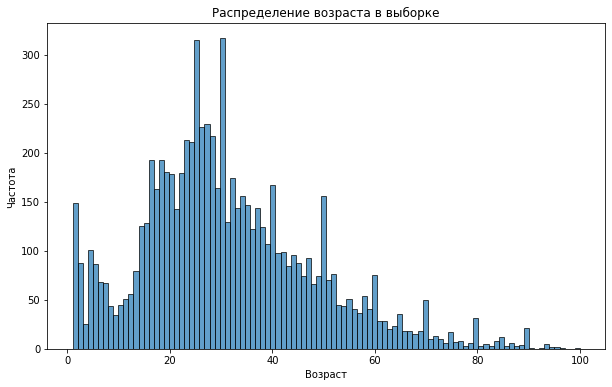

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(df['real_age'], bins=100, edgecolor='k', alpha=0.7)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

In [5]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Настроим ImageDataGenerator для загрузки изображений и отобразим несколько изображений.**

Found 7591 validated image filenames.


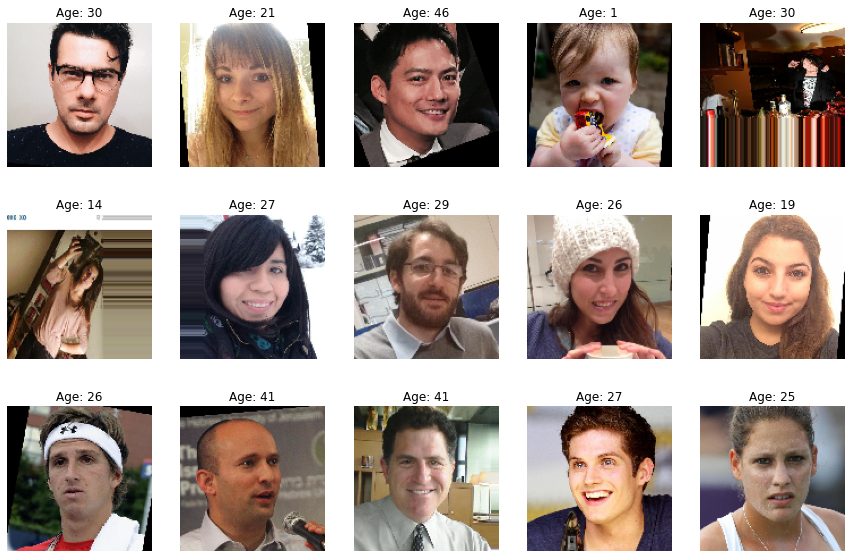

In [4]:
# Настроим ImageDataGenerator для загрузки изображений
datagen = ImageDataGenerator(rescale=1./255)

# Настроим поток изображений из dataframe
dataflow = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_folder,
    x_col='file_name',
    y_col='real_age',
    target_size=(128, 128),  # Размер изображений
    batch_size=15,
    class_mode='raw'
)

# Отобразим несколько изображений
images, ages = next(dataflow)

plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Age: {int(ages[i])}")
    plt.axis('off')
plt.show()

### Разведочный анализ данных (EDA)

#### Размер датасета

- **Общий размер датасета**: 7591 фотографии.
- **Целевой признак**: возраст (real_age).

#### Распределение целевого признака (возраста)

- **Средний возраст**: 31.2 года.
- **Стандартное отклонение**: 17.1 года.
- **Минимальный возраст**: 1 год.
- **25-й процентиль**: 20 лет.
- **Медианный возраст (50-й процентиль)**: 29 лет.
- **75-й процентиль**: 41 год.
- **Максимальный возраст**: 100 лет.

#### Выводы о распределении возраста

- Большая часть фотографий сосредоточена в возрастной группе от 20 до 41 года.
- Распределение возрастов охватывает широкий диапазон, что способствует обучению модели для различных возрастных групп.
- Наличие достаточно большого количества фотографий для каждой возрастной группы обеспечивает более надежное обучение модели.

#### Особенности данных

- Фотографии представляют собой разнообразные возрастные группы, что помогает модели обучаться на данных с различными признаками старения.
- В датасете присутствуют как молодые, так и пожилые люди, что позволяет модели генерировать более точные прогнозы для всех возрастов.
- Возможно наличие незначительных искажений в данных, таких как различия в освещении, позах и выражениях лиц.

#### Рекомендованные аугментации

- **Горизонтальные перевороты**: помогут модели быть устойчивой к различным ориентациям лиц.
- **Изменение яркости и контрастности**: поможет модели справляться с различными условиями освещения.
- **Сдвиги и повороты**: увеличат устойчивость модели к различным углам и позициям лиц.
- **Шум и размытие**: помогут модели быть устойчивой к качеству изображений.

#### Заключение

- **Размер датасета**: 7591 фотография является достаточно большим для обучения модели, хотя увеличение количества данных может улучшить производительность.
- **Распределение возраста**: сбалансированное распределение по возрастным группам способствует более надежному обучению модели.
- **Аугментации данных**: применение различных техник аугментации улучшит обобщающую способность модели и снизит вероятность переобучения.

В целом, данные и выбранные аугментации создают хорошую основу для обучения модели регрессии возраста по изображениям лиц.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen_flow = datagen.flow_from_dataframe(
        labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=15,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen_flow = datagen.flow_from_dataframe(
        labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=15,
        class_mode='raw',
        seed=12345,
        subset='validation',
        shuffle=False
    )

    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))  

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=8, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >
Train for 405 steps, validate for 102 steps
Epoch 1/8
2024-07-08 19:07:59.991532: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-08 19:08:00.396761: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
405/405 - 59s - loss: 208.2263 - mae: 10.5906 - val_loss: 391.9214 - val_mae: 14.7868
Epoch 2/8
405/405 - 48s - loss: 71.5110 - mae: 6.4462 - val_loss: 116.2089 - val_mae: 8.3055
Epoch 3/8
405/405 - 48s - loss: 37.6590 - mae: 4.7208 - val_loss: 85.6425 - val_mae: 6.9183
Epoch 4/8
405/405 - 48s - loss: 23.5091 - mae: 3.7295 - val_loss: 78.1339 - val_mae: 6.7642
Epoch 5/8
405/405 - 49s - loss: 17.0183 - mae: 3.1353 - val_loss: 73.6837 - val_mae: 6.6301
Epoch 6/8
405/405 - 48s - loss: 13.0437 - mae: 2.7662 - val_loss: 72.6021 - val_mae: 6.4619
Epoch 7/8
405/405 - 48s - loss: 11.3461 - mae: 2.5375 - val_loss: 71.0794 - val_mae: 6.4174
Epoch 8/8
405/405 - 47s - loss: 10.3018 - mae: 2.4183 - val_loss: 75.9628 - val_mae: 6.5176
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
102/102 - 9s - loss: 75.9628 - mae: 6.5176
```

## Анализ обученной модели

### Исходные данные и модель

Мы использовали модель ResNet50, предобученную на датасете ImageNet, для задачи регрессии возраста по изображениям лиц. Для обучения использовался набор данных, содержащий фотографии лиц и соответствующие возрастные метки.

### Параметры обучения

- **Оптимизатор**: Adam с начальной скоростью обучения 0.0001
- **Функция потерь**: Среднеквадратическая ошибка (MSE)
- **Метрика**: Средняя абсолютная ошибка (MAE)
- **Размер батча**: 15
- **Размер изображений**: 150x150 пикселей
- **Количество эпох**: 8

### Результаты обучения

#### Снижение ошибки

Наблюдается значительное снижение как `loss`, так и `mae` на тренировочной выборке с увеличением числа эпох, что указывает на то, что модель постепенно обучается.

#### Переобучение

Значения `val_loss` и `val_mae` уменьшаются, но начиная с определенного момента (Эпоха 5), начинают колебаться, что может указывать на начало переобучения. Переобучение проявляется в том, что ошибка на валидационной выборке не уменьшается так же стабильно, как на тренировочной.

#### Средняя абсолютная ошибка (MAE)

MAE на валидационной выборке к концу обучения составляет около 6.5 лет. Это указывает на то, что в среднем модель ошибается на 6.5 лет при предсказании возраста.

#### Стабильность обучения

Последние несколько эпох демонстрируют относительную стабильность `val_mae`, что указывает на потенциальное достижение модели своей максимальной производительности на данных.

### Рекомендации

- Можно продолжить обучение еще на несколько эпох, чтобы увидеть, не улучшится ли результат, но нужно внимательно следить за признаками переобучения.
- Можно попробовать более сложные архитектуры или увеличить размер входных изображений.
- Также стоит рассмотреть регуляризацию или техники аугментации данных, чтобы улучшить обобщающую способность модели и снизить переобучение.

### Заключение

Модель демонстрирует хорошие результаты, с учетом того, что для задачи регрессии возраста ошибка в среднем на 6.5 лет является приемлемой. Тем не менее, есть потенциал для улучшения, особенно в плане обобщающей способности модели.
